


###**EMOTION CLASSIFICATION PREDICTION SYSTEM**:



    The purpose of this classfication system is to detect the emotion of any person .


---









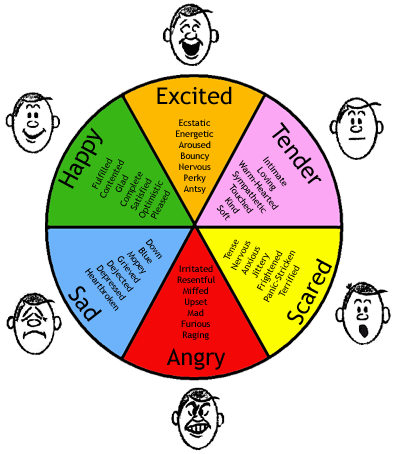


#### **Installing and Importing Libraries** 

##### Installing Libraries

In [1]:
!pip install transformers -U
!pip install pandas
!pip install numpy 
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##### Importing Libraries


In [2]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification

#### **Reading the dataset**
- Reading the labeled csv
- Reading training data
- Reading testing data
-Reading -Labeled data

This function is Returning Column names 

In [7]:
def return_column_names(file_name) :
  if file_name=='train' or file_name=='valid' :
    return ['Comment_Text','Label']
  else :
    return ['Comment_Text']


Reading Dataset

In [8]:
emotion_training_data= pd.read_csv("train_data.txt",sep=';',names=return_column_names('train'))
emotion_validation_data= pd.read_csv("val_data.txt",sep=';',names=return_column_names('valid'))
emotion_test_data= pd.read_csv("test_data.txt",sep=';',names=return_column_names('test'))

Printing Dataset

In [46]:
emotion_training_data.head(2)

,Comment_Text,Label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness


Checking how many Unique Labels we have in the output columns

In [7]:
print(f'Their are total "{len(emotion_training_data.Label.unique())}" label values present in the dataset')

Their are total "6" label values present in the dataset


#### **Preparing the dataset**


##### Removing Duplicate rows

In [8]:
emotion_training_data.drop_duplicates(inplace=True)
emotion_validation_data.drop_duplicates(inplace=True)

##### mapping data

Just want to create a dictionary to map with our dataframe

In [9]:
labeling_dict={'sadness':0,'anger':1,'love':2,'surprise':3,'fear':4,'joy':5}

In [10]:
emotion_training_data['Label']=emotion_training_data['Label'].map(labeling_dict)
emotion_validation_data['Label']=emotion_validation_data['Label'].map(labeling_dict)

In [11]:
emotion_validation_data.head(2)

,Comment_Text,Label
0,im feeling quite sad and sorry for myself but ...,0
1,i feel like i am still looking at a blank canv...,0


##### Importing Tokenizer and Bert Model

I am using bert transfromer and tokenizer to perform emotion sentiment classification

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=6)

Here X_train ,X_val, y_train ,y_val are used to convert our data_frame into list 1d array and we are tokanize our data so our algorithm will accept it .

In [13]:
X_train =emotion_training_data["Comment_Text"].to_list()
X_val=emotion_validation_data["Comment_Text"].to_list()
y_train = emotion_training_data["Label"].to_list()
y_val=emotion_validation_data["Label"].to_list()
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

Our bert algorithm will take input in the form of 

['input_ids', 'token_type_ids', 'attention_mask']

In [14]:
X_train_tokenized.keys()


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

The length is 512 because the max length is fixed in a tokinize function

In [15]:
print(X_train_tokenized['token_type_ids'][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


This is torch dataset function convert the tokanize data into ['input_ids', 'token_type_ids', 'attention_mask'] so our algorithm will accept it .

In [16]:

# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

Now our algorithm is ready to take input in the form of 
input_ids', 'token_type_ids', 'attention_mask'

In [17]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

#### **Intialize the compute metrics**

In [24]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)


    return {"accuracy": accuracy}

#### **Model Development**

##### Intialize the Model 
-- Training_Arguments :
- The output_dir 
- The num_train_epoch
- batch_size

-- Trainer :
- Model that we intialize 
- Args of Training Arguments
- training_dataset
- val_dataset
- Compute metrics like recall , precision ,accuracy



In [25]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    num_train_epochs=1,
    per_device_train_batch_size=50

)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


##### **Train Deep Learning Bert Model**

In [26]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 15999
  Num Epochs = 1
  Instantaneous batch size per device = 50
  Total train batch size (w. parallel, distributed & accumulation) = 50
  Gradient Accumulation steps = 1
  Total optimization steps = 320
  Number of trainable parameters = 109486854


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=320, training_loss=0.1587294340133667, metrics={'train_runtime': 218.6571, 'train_samples_per_second': 73.169, 'train_steps_per_second': 1.463, 'total_flos': 715314162582468.0, 'train_loss': 0.1587294340133667, 'epoch': 1.0})

#### **Model Validation**

In [28]:
Model_validation_metrics=trainer.evaluate()


***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8


In [29]:
Loss=Model_validation_metrics['eval_loss']
Accuracy=Model_validation_metrics['eval_accuracy']



**The validation loss is less it means our model is not overfitting and will give us high quality results and the overall accuracy is also good .**

In [36]:
print(f'Validation_Loss is : {Loss}, and Validation_Accuracy is : {Accuracy}')

Validation_Loss is : 0.16081689298152924, and Validation_Accuracy is : 0.9355


#### **Saving Model** 

In [29]:
#trainer.save_model('CustomModel')
#tokenizer.save_pretrained("Tokenizer")

('Tokenizer/tokenizer_config.json',
 'Tokenizer/special_tokens_map.json',
 'Tokenizer/vocab.txt',
 'Tokenizer/added_tokens.json')

#### **Loading Model and Tokanizer for Prediction**

In [30]:
#tokenizer = BertTokenizer.from_pretrained('Tokenizer')
#model = BertForSequenceClassification.from_pretrained("CustomModel")

#### **Performing Prediction on the test data** 

We will map our results with this dictionary

In [31]:
labeling_dict={0:'sadness',1:'anger',2:'love',3:'surprise',4:'fear',5:'joy'}

In [35]:
append_results=[]
for examples in emotion_test_data['Comment_Text'].to_list() :
  encoded_input = tokenizer(examples, return_tensors='pt',padding=True,truncation=True)
  output = model(**encoded_input)
  logits = output.logits.detach().cpu().numpy() 
  y_pred = np.argmax(logits,axis=-1)
  append_results.append(labeling_dict[y_pred[0]])

#### **Saving Results**

In [36]:
emotion_test_data['Label']=append_results

In [27]:
emotion_test_data.to_csv('TestfileResults.csv',index=False)